<a href="https://colab.research.google.com/github/feist000/Project/blob/master/%EA%B3%A0%EC%96%91%EC%8B%9C%20%EA%B3%B5%EA%B3%B5%EC%9E%90%EC%A0%84%EA%B1%B0%20%EC%8A%A4%ED%85%8C%EC%9D%B4%EC%85%98/1_%EA%B3%B5%EA%B3%B5_%EC%9E%90%EC%A0%84%EA%B1%B0_%EC%9D%B4%EC%9A%A9_%ED%98%84%ED%99%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 공공 자전거 스테이션 현황
 ##		1) 시간대별 이용 현황 	
 ##		2) 시간대별 사용빈도가  높은 대여/반납 스테이션 위치
 ##    3) 사용량에 따른 자전거스테이션 위치

In [ ]:
import pathlib
import random
from functools import reduce
from collections import defaultdict

import pandas as pd
import geopandas as gpd
import folium
import shapely
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xgboost
import sklearn.cluster
import tensorflow as tf

from geoband import API

/opt/app-root/lib/python3.6/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 데이터 읽어오기
input_path = pathlib.Path('./input')
if not input_path.is_dir():
    input_path.mkdir()

API.GetCompasData('SBJ_2007_001', '1', input_path.joinpath('01.운영이력.csv'))
API.GetCompasData('SBJ_2007_001', '2', input_path.joinpath('02.자전거스테이션.csv'))
API.GetCompasData('SBJ_2007_001', '6', input_path.joinpath('17.일반건물 분포도(100M X 100M).geojson'))
API.GetCompasData('SBJ_2007_001', '15', input_path.joinpath('15.도로명주소_건물.geojson'))
API.GetCompasData('SBJ_2007_001', '16', input_path.joinpath('16.도로명주소_도로.geojson'))
API.GetCompasData('SBJ_2007_001', '19', input_path.joinpath('19.전철역_공간정보.csv'))
API.GetCompasData('SBJ_2007_001', '20', input_path.joinpath('20.고양시 버스정류소.csv'))

for path in list(input_path.glob('*.csv')) + list(input_path.glob('*.geojson')):
    print(path)

input/01.운영이력.csv
input/02.자전거스테이션.csv
input/19.전철역_공간정보.csv
input/20.고양시 버스정류소.csv
input/07.인구통계.csv
input/운영이력.csv
input/자전거스테이션.csv
input/전철역_공간정보.csv
input/고양시 버스정류소.csv
input/17.일반건물 분포도(100M X 100M).geojson
input/15.도로명주소_건물.geojson
input/16.도로명주소_도로.geojson
input/06.인구(거주)분포도(100M_X_100M).geojson
input/일반건물 분포도(100M X 100M).geojson
input/도로명주소_건물.geojson
input/도로명주소_도로.geojson
input/34.고양시_행정경계(행정동기준).geojson


In [ ]:
bicycle_now=pd.read_csv(input_path.joinpath('01.운영이력.csv'))

/opt/app-root/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
bicycle_now.describe(include='all')

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS
count,3.142688e+06,3142688.0,3142688,3.142688e+06,3.142688e+06,3142688,3.142688e+06,3.142688e+06,2.747029e+06,3142688.0,3.142688e+06,3.142685e+06,3142688,410039.000000
unique,NaN,NaN,3056724,NaN,NaN,3044089,NaN,NaN,NaN,31.0,NaN,NaN,3932,NaN
top,NaN,NaN,2019-05-08 18:19:21,NaN,NaN,2019-10-14 19:00:06,NaN,NaN,NaN,3.0,NaN,NaN,1A8440000002DC,NaN
freq,NaN,NaN,4,NaN,NaN,23,NaN,NaN,NaN,816117.0,NaN,NaN,2891,NaN
mean,1.882270e+07,2.0,NaN,2.487533e+02,1.335679e+01,NaN,2.175205e+02,1.119356e+01,4.895855e+03,NaN,1.315026e+05,9.174356e+05,NaN,1.121984
std,1.674327e+06,0.0,NaN,6.367190e+01,7.404129e+00,NaN,1.017983e+02,8.703353e+00,1.264047e+04,NaN,9.720860e+04,1.587276e+06,NaN,0.590959
min,1.594554e+07,2.0,NaN,1.010000e+02,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,1.000000
25%,1.735176e+07,2.0,NaN,2.130000e+02,8.000000e+00,NaN,2.030000e+02,3.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,1.000000
50%,1.883170e+07,2.0,NaN,2.460000e+02,1.300000e+01,NaN,2.320000e+02,1.100000e+01,0.000000e+00,NaN,1.849010e+05,0.000000e+00,NaN,1.000000
75%,2.029006e+07,2.0,NaN,3.090000e+02,1.800000e+01,NaN,3.070000e+02,1.700000e+01,0.000000e+00,NaN,2.065770e+05,3.191189e+06,NaN,1.000000


## 01.운영이력 컬럼
#### - LEAS_NO 대여 번호
#### - LEAS_DATE 대여 시간 
#### - LEAS_STATION 대여 스테이션 번호 
#### - LEAS_DEF_NO 대여 거치대 번호
#### - RTN_DATE 반납 시간 
#### - RTN_STATION 반납 스테이션 번호 !
#### - RTN_DEF_NO 반납 거치대 번호
#### - RTN_PROCESS 관제반납구분값 (01:관제반납/02:관리자반납/03:관리자반출/04:타 사용자 반납/05:다른 사용자 반출)
#### - TRNV_QTY 추정 이동 거리(m) ! -> 평균 이동거리
#### - MEMB_DIV 회원 구분(비회원은 99이며 나머지는 정회원)
#### - MEMB_NO 회원 번호
#### - TEMP_MEMB_NO 비회원 번호
#### - BIKE_TAG 자전거 번호

## 1)시간대별 자전거 스테이션 이용현황

### (1) 대여 자전거 스테이션 현황

In [ ]:
# 대여/반납 스테이션으로 데이터 분리

bicycle_LEAS=bicycle_now[['LEAS_DATE','LEAS_STATION']]
bicycle_RTN=bicycle_now[['RTN_DATE', 'RTN_STATION']]

In [ ]:
#자전거 대여(날짜/스테이션) - bicycle_LEAS
# 시간만 분리

# 먼저 데이터['LEAS_DATE'] 타입이 object 인지 확인
bicycle_LEAS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142688 entries, 0 to 3142687
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   LEAS_DATE     object
 1   LEAS_STATION  int64 
dtypes: int64(1), object(1)
memory usage: 48.0+ MB


In [ ]:
#'년원일'과 ' 시분초' 쪼개기
bicycle_LEAS['tempDATE']=bicycle_LEAS.LEAS_DATE.apply(lambda x:x.split())


# tempDATE에서 시간만 분리
bicycle_LEAS['LEAS_hour']=bicycle_LEAS.tempDATE.apply(lambda x:x[1].split(":")[0])

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### bicycle_LEAS  데이터 확인

In [ ]:
print(bicycle_LEAS.head(3))
print(bicycle_LEAS.tail(3))

             LEAS_DATE  LEAS_STATION                tempDATE LEAS_hour
0  2017-01-01 00:00:41           213  [2017-01-01, 00:00:41]        00
1  2017-01-01 00:01:03           231  [2017-01-01, 00:01:03]        00
2  2017-01-01 00:01:50           119  [2017-01-01, 00:01:50]        00
                   LEAS_DATE  LEAS_STATION                tempDATE LEAS_hour
3142685  2019-12-31 23:55:27           333  [2019-12-31, 23:55:27]        23
3142686  2019-12-31 23:59:14           264  [2019-12-31, 23:59:14]        23
3142687  2019-12-31 23:59:30           214  [2019-12-31, 23:59:30]        23


In [ ]:
# 시간(컬럼[LEAS_hour]) 0-23으로 분리
# 시간대 별로 방문하는 스테이션 갯수 카운트
# 대여시간이 많은 시간대에 자전거 스테이션이 어떻게 분포하는가를 확인
# 시각화


bicycle_LEAS.groupby('LEAS_hour')['LEAS_STATION']
bicycle_LEAS.head()

,LEAS_DATE,LEAS_STATION,tempDATE,LEAS_hour
0,2017-01-01 00:00:41,213,"[2017-01-01, 00:00:41]",00
1,2017-01-01 00:01:03,231,"[2017-01-01, 00:01:03]",00
2,2017-01-01 00:01:50,119,"[2017-01-01, 00:01:50]",00
3,2017-01-01 00:02:09,121,"[2017-01-01, 00:02:09]",00
4,2017-01-01 00:03:32,320,"[2017-01-01, 00:03:32]",00


/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='LEAS_hour'>

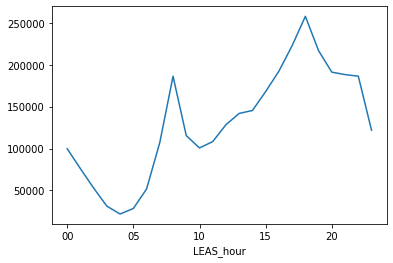

In [ ]:
#대여시간을 기준으로 groupby한 후 count
bicycle_LEAS.groupby('LEAS_hour')['LEAS_STATION'].count().plot()

### (2) 반납 자전거 스테이션 현황

In [ ]:
# 반납도 대여와 동일한 방식으로 시간대별 스테이션 이용현황 확인
bicycle_RTN['tempDATE']=bicycle_RTN.RTN_DATE.apply(lambda x:x.split())

# 시간 대 확인
bicycle_RTN['RTN_hour']=bicycle_RTN.tempDATE.apply(lambda x:x[1].split(":")[0])

bicycle_RTN.head(3)

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,RTN_DATE,RTN_STATION,tempDATE,RTN_hour
0,2017-01-01 00:13:52,260,"[2017-01-01, 00:13:52]",00
1,2017-01-01 00:50:24,231,"[2017-01-01, 00:50:24]",00
2,2017-01-01 01:01:50,0,"[2017-01-01, 01:01:50]",01


/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='RTN_hour'>

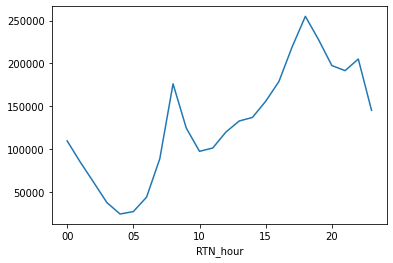

In [ ]:
# 시간(컬럼[RTN_hour]) 0-23으로 분리
# 시간대 별로 방문하는 스테이션 갯수 카운트
# 반납시간이 많은 시간대에 자전거 스테이션이 어떻게 분포하는가 확인
# 시각화

bicycle_RTN.groupby('RTN_hour')['RTN_STATION']
bicycle_RTN.groupby('RTN_hour')['RTN_STATION'].count().plot()

### - 시간대별로 대여/반납 빈도 추이가 유사

## 2) 대여 시간대를 기준으로 출근/퇴근/점심/막차 이후 사용빈도 분석

In [ ]:
# biclcye_now에 새로운 칼럼['tempDATE'] 추가
# 시간 값만 모아 ['LEAS_hour']에 추가
bicycle_now['tempDATE']=bicycle_now.LEAS_DATE.apply(lambda x: x.split())
bicycle_now['LEAS_hour']=bicycle_now.tempDATE.apply(lambda x:x[1].split(":")[0])

In [ ]:
#출근 시간 별 시리즈 생성
chulgeun07=bicycle_now['LEAS_hour']=='07'
chulgeun08=bicycle_now['LEAS_hour']=='08'
chulgeun09=bicycle_now['LEAS_hour']=='09'

In [ ]:
# 해당 시리즈를 bicycle_now의 칼럼으로 추가
chulgeun07=bicycle_now[chulgeun07]
chulgeun08=bicycle_now[chulgeun08]
chulgeun09=bicycle_now[chulgeun09]

In [ ]:
# 해당 시리즈를 bicycle_now의 칼럼으로 추가
bicycle_chulgeun=chulgeun07.append([chulgeun08, chulgeun09])
bicycle_chulgeun.head(3)

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,tempDATE,LEAS_hour
325,15946095,2,2017-01-01 07:02:56,217,16,2017-01-01 07:10:24,207,20,0.0,12,162376,0.0,1A84400000F363,NaN,"[2017-01-01, 07:02:56]",07
326,15946097,2,2017-01-01 07:06:53,203,20,2017-01-01 07:52:56,203,20,0.0,1,187752,0.0,1A84400000F54F,NaN,"[2017-01-01, 07:06:53]",07
327,15946098,2,2017-01-01 07:08:26,203,14,2017-01-01 07:52:58,203,14,0.0,99,0,3185290.0,1A84400000F545,NaN,"[2017-01-01, 07:08:26]",07


## 출근 시간 자전거 스테이션 현황

In [ ]:
# 대여-반납 현황이 시간대별로 유사하기 때문에 대여 관련 자료만 추출한다.

bicycle_chulgeun_LEAS=bicycle_chulgeun[['LEAS_NO', 'LEAS_DATE', 'LEAS_STATION', 'LEAS_DEF_NO']]
bicycle_chulgeun_LEAS

,LEAS_NO,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO
325,15946095,2017-01-01 07:02:56,217,16
326,15946097,2017-01-01 07:06:53,203,20
327,15946098,2017-01-01 07:08:26,203,14
328,15946099,2017-01-01 07:13:04,328,15
329,15946100,2017-01-01 07:14:31,311,15
...,...,...,...,...
3141926,21716849,2019-12-31 09:53:13,319,15
3141927,21716851,2019-12-31 09:54:08,252,20
3141928,21716859,2019-12-31 09:55:53,253,21
3141929,21716864,2019-12-31 09:57:42,320,17


In [ ]:
# 결측값 확인
bicycle_chulgeun_LEAS.isnull().sum()

LEAS_NO         0
LEAS_DATE       0
LEAS_STATION    0
LEAS_DEF_NO     0
dtype: int64

In [ ]:
#LEAS_STATION의 대여 횟수
LEAS_counts1=bicycle_chulgeun_LEAS['LEAS_STATION'].value_counts()

In [ ]:
# 막차 시간대 대여횟수를 하나의 데이터 프레임으로 변형

hour_07to09 = LEAS_counts1.rename_axis('LEAS_STATION').reset_index(name='counts')
hour_07to09

,LEAS_STATION,counts
0,321,9261
1,311,8060
2,245,7912
3,343,7724
4,229,7569
...,...,...
150,171,185
151,265,166
152,264,134
153,351,73


In [ ]:
# 결측값 확인
bicycle_chulgeun_LEAS.isnull().sum()

LEAS_NO         0
LEAS_DATE       0
LEAS_STATION    0
LEAS_DEF_NO     0
dtype: int64

In [ ]:
#LEAS_STATION의 대여 횟수
LEAS_counts=bicycle_chulgeun_LEAS['LEAS_STATION'].value_counts()

In [ ]:
hour_07to09 = LEAS_counts.rename_axis('LEAS_STATION').reset_index(name='counts')
hour_07to09

,LEAS_STATION,counts
0,210,15446
1,260,6489
2,259,5992
3,306,5298
4,342,4951
...,...,...
151,351,37
152,256,37
153,992,33
154,263,16


In [ ]:
# 해당 스테이션별 위도 경도 입히기

bicycle_station=pd.read_csv(input_path.joinpath('02.자전거스테이션.csv'))

In [ ]:
hour_07to09['위도']=0
hour_07to09['경도']=0

for i in range(len(hour_07to09['LEAS_STATION'])):
    for j in range(len(bicycle_station['Station_ID'])):
        if hour_07to09['LEAS_STATION'].iloc[i]==bicycle_station['Station_ID'].iloc[j]:
            hour_07to09['위도'].iloc[i]=bicycle_station['위도'].iloc[j]
            hour_07to09['경도'].iloc[i]=bicycle_station['경도'].iloc[j]

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
hour_07to09.head()

,LEAS_STATION,counts,위도,경도
0,321,9261,37.681812,126.769340
1,311,8060,37.670203,126.768394
2,245,7912,37.675567,126.784853
3,343,7724,37.675036,126.768351
4,229,7569,37.672328,126.785754


In [ ]:
#점심 시간 별 시리즈 생성

lunch12=bicycle_now['LEAS_hour']=='12'
lunch13=bicycle_now['LEAS_hour']=='13'
lunch14=bicycle_now['LEAS_hour']=='14'

In [ ]:
#해당 시리즈를 bicycle_now의 칼럼으로 추가
lunch12=bicycle_now[lunch12]
lunch13=bicycle_now[lunch13]
lunch14=bicycle_now[lunch14]

In [ ]:
#해당 시리즈를 bicycle_now의 칼럼으로 추가
bicycle_lunch=lunch12.append([lunch13, lunch14])
bicycle_lunch.head(3)

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,tempDATE,LEAS_hour
524,15946641,2,2017-01-01 12:00:18,309,30,2017-01-01 12:08:14,0,0,NaN,12,88663,0.0,1A84400000F2E7,1.0,"[2017-01-01, 12:00:18]",12
525,15946642,2,2017-01-01 12:00:50,253,5,2017-01-01 12:44:42,254,20,0.0,99,0,3185350.0,1A84400000099B,NaN,"[2017-01-01, 12:00:50]",12
526,15946643,2,2017-01-01 12:03:35,254,14,2017-01-01 12:53:01,254,19,0.0,99,0,3185352.0,1A84400000F368,NaN,"[2017-01-01, 12:03:35]",12


In [ ]:
# 점심시간대 자전거 스테이션 현황
bicycle_lunch_LEAS=bicycle_lunch[['LEAS_NO', 'LEAS_DATE', 'LEAS_STATION', 'LEAS_DEF_NO']]
bicycle_lunch_LEAS

,LEAS_NO,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO
524,15946641,2017-01-01 12:00:18,309,30
525,15946642,2017-01-01 12:00:50,253,5
526,15946643,2017-01-01 12:03:35,254,14
527,15946644,2017-01-01 12:03:52,250,28
528,15946645,2017-01-01 12:05:48,254,12
...,...,...,...,...
3142141,21717624,2019-12-31 14:54:26,318,10
3142142,21717629,2019-12-31 14:56:55,345,19
3142143,21717633,2019-12-31 14:58:43,212,5
3142144,21717634,2019-12-31 14:58:55,212,22


In [ ]:
#결측값 확인
bicycle_lunch_LEAS.isnull().sum()

LEAS_NO         0
LEAS_DATE       0
LEAS_STATION    0
LEAS_DEF_NO     0
dtype: int64

In [ ]:
#LEAS_STATION의 대여 횟수
LEAS_counts2= bicycle_lunch_LEAS['LEAS_STATION'].value_counts()

In [ ]:
# 점심시간대 대여 횟수를 하나의 데이터 프레임으로 변형
hour_12to14=LEAS_counts2.rename_axis('LEAS_STATION').reset_index(name='counts')
hour_12to14

,LEAS_STATION,counts
0,254,12419
1,253,12399
2,309,11303
3,259,9906
4,310,9608
...,...,...
150,992,175
151,265,161
152,264,97
153,351,73


In [ ]:
hour_12to14['위도']=0
hour_12to14['경도']=0

for i in range(len(hour_12to14['LEAS_STATION'])):
    for j in range(len(bicycle_station['Station_ID'])):
        if hour_12to14['LEAS_STATION'].iloc[i]==bicycle_station['Station_ID'].iloc[j]:
            hour_12to14['위도'].iloc[i]=bicycle_station['위도'].iloc[j]
            hour_12to14['경도'].iloc[i]=bicycle_station['경도'].iloc[j]

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
hour_12to14.head()

,LEAS_STATION,counts,위도,경도
0,254,12419,37.655647,126.768352
1,253,12399,37.663241,126.762162
2,309,11303,37.671278,126.761898
3,259,9906,37.656722,126.771620
4,310,9608,37.669687,126.761237


In [ ]:
# 퇴근 시간 별 시리즈 생성
toegeun16=bicycle_now['LEAS_hour']=='16'
toegeun17=bicycle_now['LEAS_hour']=='17'
toegeun18=bicycle_now['LEAS_hour']=='18'
toegeun19=bicycle_now['LEAS_hour']=='19'

In [ ]:
# 해당 시리즈를 bicycle_now의 칼럼으로 추가
toegeun16=bicycle_now[toegeun16]
toegeun17=bicycle_now[toegeun17]
toegeun18=bicycle_now[toegeun18]
toegeun19=bicycle_now[toegeun19]

In [ ]:
bicycle_toegeun=toegeun16.append([toegeun17, toegeun18, toegeun19])
bicycle_toegeun

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,tempDATE,LEAS_hour
876,15947200,2,2017-01-01 16:01:24,308,2,2017-01-01 16:16:49,330,2,21559.0,3,187628,0.0,1A8440000009B3,NaN,"[2017-01-01, 16:01:24]",16
877,15947203,2,2017-01-01 16:02:04,308,9,2017-01-01 16:28:30,330,7,23988.0,2,187831,0.0,1A84400000F50F,NaN,"[2017-01-01, 16:02:04]",16
878,15947204,2,2017-01-01 16:02:53,104,1,2017-01-01 16:15:14,330,16,9190.0,99,0,3185522.0,1A844000000092,NaN,"[2017-01-01, 16:02:53]",16
879,15947205,2,2017-01-01 16:03:01,257,35,2017-01-01 16:44:13,207,5,0.0,3,187041,0.0,1A8440000002F8,NaN,"[2017-01-01, 16:03:01]",16
880,15947206,2,2017-01-01 16:03:33,252,20,2017-01-01 16:49:24,252,20,0.0,99,0,3185523.0,1A844000000382,NaN,"[2017-01-01, 16:03:33]",16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142517,21718287,2,2019-12-31 19:53:30,203,17,2019-12-31 19:55:46,202,7,0.0,3,89273,0.0,1A84400000FDC4,NaN,"[2019-12-31, 19:53:30]",19
3142518,21718289,2,2019-12-31 19:54:22,248,2,2019-12-31 20:19:04,330,14,0.0,3,229913,0.0,1A84400000FC95,NaN,"[2019-12-31, 19:54:22]",19
3142519,21718291,2,2019-12-31 19:54:47,321,21,2019-12-31 20:50:17,0,0,NaN,36,180156,0.0,1A84400000F6A8,1.0,"[2019-12-31, 19:54:47]",19
3142520,21718295,2,2019-12-31 19:55:41,215,8,2019-12-31 20:08:35,231,16,0.0,12,170365,0.0,1A84400000FD10,NaN,"[2019-12-31, 19:55:41]",19


In [ ]:
## 퇴근 시간 대 자전거 스테이션 현황
bicycle_toegeun_LEAS=bicycle_toegeun[['LEAS_NO', 'LEAS_DATE', 'LEAS_STATION', 'LEAS_DEF_NO']]
bicycle_toegeun_LEAS

,LEAS_NO,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO
876,15947200,2017-01-01 16:01:24,308,2
877,15947203,2017-01-01 16:02:04,308,9
878,15947204,2017-01-01 16:02:53,104,1
879,15947205,2017-01-01 16:03:01,257,35
880,15947206,2017-01-01 16:03:33,252,20
...,...,...,...,...
3142517,21718287,2019-12-31 19:53:30,203,17
3142518,21718289,2019-12-31 19:54:22,248,2
3142519,21718291,2019-12-31 19:54:47,321,21
3142520,21718295,2019-12-31 19:55:41,215,8


In [ ]:
#결측값 확인
bicycle_toegeun_LEAS.isnull().sum()

LEAS_NO         0
LEAS_DATE       0
LEAS_STATION    0
LEAS_DEF_NO     0
dtype: int64

In [ ]:
#LEAS_STATION의 대여횟수
LEAS_counts3=bicycle_toegeun_LEAS['LEAS_STATION'].value_counts()

In [ ]:
# 퇴근 시간대 대여횟수를 하나의 데이터 프레임으로 변형
hour_16to19=LEAS_counts3.rename_axis('LEAS_STATION').reset_index(name='counts')
hour_16to19

,LEAS_STATION,counts
0,254,29333
1,253,26986
2,309,25843
3,259,25659
4,310,22368
...,...,...
151,264,147
152,265,130
153,351,116
154,263,46


In [ ]:
hour_16to19['위도']=0
hour_16to19['경도']=0

for i in range(len(hour_16to19['LEAS_STATION'])):
    for j in range(len(bicycle_station['Station_ID'])):
        if hour_16to19['LEAS_STATION'].iloc[i]==bicycle_station['Station_ID'].iloc[j]:
            hour_16to19['위도'].iloc[i]=bicycle_station['위도'].iloc[j]
            hour_16to19['경도'].iloc[i]=bicycle_station['경도'].iloc[j]

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
hour_16to19.head()

,LEAS_STATION,counts,위도,경도
0,254,29333,37.655647,126.768352
1,253,26986,37.663241,126.762162
2,309,25843,37.671278,126.761898
3,259,25659,37.656722,126.771620
4,310,22368,37.669687,126.761237


## 막차 시간 이후 자전거 스테이션 현황

In [ ]:
bicycle_makcha_LEAS=bicycle_makcha[['LEAS_NO', 'LEAS_DATE', 'LEAS_STATION', 'LEAS_DEF_NO']]
bicycle_makcha_LEAS

,LEAS_NO,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO
0,15945541,2017-01-01 00:00:41,213,18
1,15945542,2017-01-01 00:01:03,231,4
2,15945543,2017-01-01 00:01:50,119,14
3,15945544,2017-01-01 00:02:09,121,17
4,15945545,2017-01-01 00:03:32,320,29
...,...,...,...,...
3141701,21716337,2019-12-31 03:12:34,307,13
3141702,21716339,2019-12-31 03:16:21,238,2
3141703,21716342,2019-12-31 03:22:43,210,10
3141704,21716346,2019-12-31 03:28:54,306,14


In [ ]:
# 결측값 확인
bicycle_makcha_LEAS.isnull().sum()

LEAS_NO         0
LEAS_DATE       0
LEAS_STATION    0
LEAS_DEF_NO     0
dtype: int64

In [ ]:
#LEAS_STATION의 대여 횟수
LEAS_counts=bicycle_makcha_LEAS['LEAS_STATION'].value_counts()

In [ ]:
# 막차 시간대 대여횟수를 하나의 데이터프레임으로 변형
hour_0to3 = LEAS_counts.rename_axis('LEAS_STATION').reset_index(name='counts')
hour_0to3

,LEAS_STATION,counts
0,210,15446
1,260,6489
2,259,5992
3,306,5298
4,342,4951
...,...,...
151,351,37
152,256,37
153,992,33
154,263,16


In [ ]:
hour_0to3['위도']=0
hour_0to3['경도']=0

for i in range(len(hour_0to3['LEAS_STATION'])):
    for j in range(len(bicycle_station['Station_ID'])):
        if hour_0to3['LEAS_STATION'].iloc[i]==bicycle_station['Station_ID'].iloc[j]:
            hour_0to3['위도'].iloc[i]=bicycle_station['위도'].iloc[j]
            hour_0to3['경도'].iloc[i]=bicycle_station['경도'].iloc[j]

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
hour_0to3.head()

,LEAS_STATION,counts,위도,경도
0,210,15446,37.663673,126.767099
1,260,6489,37.662030,126.768952
2,259,5992,37.656722,126.771620
3,306,5298,37.675838,126.747974
4,342,4951,37.677995,126.766402


## 3)사용빈도에 따른 자전거 스테이션별 위치

In [ ]:
station_info=pd.read_csv(input_path.joinpath('02.자전거스테이션.csv'))

In [ ]:
#bicycle_now에서 대여/반납 정류소만 추출
bicycle=bicycle_now[["LEAS_STATION", "RTN_STATION"]]

In [ ]:
# 대여와 반납을 따로 나누어 추출함
bicycle_leas = pd.DataFrame(bicycle_now["LEAS_STATION"])    # 대여 정류소만 뽑음
bicycle_rtn = pd.DataFrame(bicycle_now["RTN_STATION"])       # 반납 정류소만 뽑음

bicycle_leas['X'] = 0
bicycle_leas['Y'] = 0
bicycle_leas['count'] = 1

In [ ]:
# 대여한 정류소들 위치 채우기
bicycle_leas = bicycle_leas.groupby(by = ['LEAS_STATION']).sum()

bicycle_leas.reset_index()

bicycle_leas = bicycle_leas.reset_index().rename(columns={"index": "LEAS_STATION"})

for i in range(len(bicycle_leas['LEAS_STATION'])):
    for j in range(len(station_info['Station_ID'])):
        if bicycle_leas['LEAS_STATION'].iloc[i] == station_info['Station_ID'].iloc[j] :
            bicycle_leas['X'].iloc[i] = station_info['위도'].iloc[j]
            bicycle_leas['Y'].iloc[i] = station_info['경도'].iloc[j]
            break

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
bicycle_leas = bicycle_leas.sort_values(by ='count', ascending=False)

bicycle_leas = bicycle_leas.reset_index()

del bicycle_leas['index']
bicycle_leas

,LEAS_STATION,X,Y,count
0,253,37.663241,126.762162,83134
1,254,37.655647,126.768352,78594
2,309,37.671278,126.761898,78272
3,259,37.656722,126.771620,70746
4,210,37.663673,126.767099,69549
...,...,...,...,...
151,265,37.661296,126.750847,767
152,264,37.664403,126.748019,688
153,351,37.702259,126.767231,473
154,263,37.661579,126.747736,253


In [ ]:
# 완료된 파일을 csv로 저장하기
# 모든 csv파일은 QGIS로 시각화할 것
bicycle_leas.to_csv('bicycle_leas.csv',mode='w')

bicycle_rtn.to_csv('bicycle_rtn.csv',mode='w')

In [ ]:
# groupby와 count로 스테이션별로 총 대여가 얼마나 이루어졌는지 보기
a_leas = bicycle_leas.groupby(by='LEAS_STATION').count()
b_leas = a_leas.sort_values(by='X',ascending=False)

In [ ]:
# 집계된 자료 살펴보기 = 대여수가 높은 10개 스테이션
b_leas.head(10)

,X,Y,count
LEAS_STATION,,,
101,1,1,1
263,1,1,1
256,1,1,1
257,1,1,1
258,1,1,1
259,1,1,1
260,1,1,1
261,1,1,1
262,1,1,1


In [ ]:
# 집계된 자료 살펴보기 - 대여수가 낮은 10개 스테이션
b_leas.tail(10)

,X,Y,count
LEAS_STATION,,,
173,1,1,1
176,1,1,1
177,1,1,1
178,1,1,1
201,1,1,1
202,1,1,1
203,1,1,1
204,1,1,1
205,1,1,1


In [ ]:
# 불필요한 칼럼 삭제, 이름 재설정
del b_leas['X']
b_leas = b_leas.rename(columns = {"Y":"정류장 이용 건수"})

In [ ]:
b_leas

,정류장 이용 건수,count
LEAS_STATION,,
101,1,1
263,1,1
256,1,1
257,1,1
258,1,1
...,...,...
202,1,1
203,1,1
204,1,1


## 대여가 많은/적은 TOP10, TOP20 자전거 스테이션 정보 추출

In [ ]:
# 대여 많은 순 TOP10 뽑아 csv파일로 저장하기
s_1= b_leas.head(10)
s_1.to_csv('top_leas_1.csv',mode='w')

In [ ]:
# 대여 많은 순 TOP20 뽑아 csv파일로 저장하기
s_2 = b_leas.head(20)
s_2.to_csv('top_leas_2.csv',mode='w')

In [ ]:
# 대여 적은 순 TOP10 뽑아 csv파일로 저장하기
s_tail_1= b_leas.tail(10)
s_tail_1.to_csv('low_leas_1.csv',mode='w')

# 대여 적은 순 TOP20 뽑아 csv파일로 저장하기
s_tail_2 = b_leas.tail(20)
s_tail_2.to_csv('low_leas_2.csv',mode='w')

In [ ]:
# 반납
bicycle_rtn['X'] = 0
bicycle_rtn['Y'] = 0
bicycle_rtn['count'] = 1

In [ ]:
bicycle_rtn = bicycle_rtn.groupby(by = ['RTN_STATION']).sum()

bicycle_rtn.reset_index()

bicycle_rtn = bicycle_rtn.reset_index().rename(columns={"index": "RTN_STATION"})

for i in range(len(bicycle_rtn['RTN_STATION'])):
    for j in range(len(station_info['Station_ID'])):
        if bicycle_rtn['RTN_STATION'].iloc[i] == station_info['Station_ID'].iloc[j] :
            bicycle_rtn['X'].iloc[i] = station_info['위도'].iloc[j]
            bicycle_rtn['Y'].iloc[i] = station_info['경도'].iloc[j]
            break
bicycle_rtn = bicycle_rtn.sort_values(by ='count', ascending=False)

bicycle_rtn = bicycle_rtn.reset_index()

del bicycle_rtn['index']
bicycle_rtn

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,RTN_STATION,X,Y,count
0,0,0.000000,0.000000,398234
1,253,37.663241,126.762162,83718
2,254,37.655647,126.768352,81279
3,309,37.671278,126.761898,75719
4,210,37.663673,126.767099,72191
...,...,...,...,...
153,264,37.664403,126.748019,759
154,263,37.661579,126.747736,425
155,351,37.702259,126.767231,406
156,998,0.000000,0.000000,21


In [ ]:
# 반납 관련 데이터도 csv로 저장
# QGIS로 시각화할 것

bicycle_rtn.to_csv('bicycle_rtn.csv',mode='w')

In [ ]:
#RTN으로 파일만들기 - b_leas와 같은 작업
a_rtn = bicycle_rtn.groupby(by='RTN_STATION').count()

# 많은 순으로 뽑음
b_rtn = a_rtn.sort_values(by='X',ascending=False)
del b_rtn['X']
b_rtn = b_rtn.rename(columns = {"Y":"정류장 이용 건수"})

In [ ]:
# 대여가 많은 순으로 정류장 number를 뽑은 데이터
b_leas 

,X,Y,count
LEAS_STATION,,,
101,1,1,1
263,1,1,1
256,1,1,1
257,1,1,1
258,1,1,1
...,...,...,...
202,1,1,1
203,1,1,1
204,1,1,1


In [ ]:
# 반납이 많은 순으로 정류장 number를 뽑은 데이터
b_rtn

,정류장 이용 건수,count
RTN_STATION,,
0,1,1
263,1,1
256,1,1
257,1,1
258,1,1
...,...,...
202,1,1
203,1,1
204,1,1


### 반납이 많은/적은 TOP10, TOP20 자전거 스테이션 정보 추출

In [ ]:
# 반납 많은 순 TOP10 뽑아 csv파일로 저장하기
a_1 = b_rtn.head(10)
a_1.to_csv('top_rtn_1.csv',mode='w')

In [ ]:
# 반납 많은 순 TOP20 뽑아 csv파일로 저장하기
a_2 = b_rtn.head(20)
a_2.to_csv('top_rtn_2.csv',mode='w')